# 펀드 평가 시스템

## Get fund data

In [1]:
import requests
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import plotly
import plotly.express as px
import plotly.graph_objects as go

import yaml
from tqdm import tqdm

In [2]:
# pd.options.plotting.backend = "plotly"
pd.options.plotting.backend = "matplotlib"

In [3]:
cur_path = Path('.').resolve()
data_path = cur_path / "data"

## 펀드 데이터 다운로드

In [4]:
with open("funds.yaml", "r", encoding='utf-8') as stream:
    funds = yaml.safe_load(stream)
    funds = funds["woori_best_funds"]

In [5]:
len(funds)

13

In [6]:
fund_data = funds[0]
fund_data

{'name': '한국투자한국의제4차산업혁명증권자투자신탁 1(주식)',
 'standardCd': 'KR5101521619',
 'companyCd': 'A01001',
 'is_domestic': True,
 'kind': 'stock'}

In [7]:
def get_xml_payload(fund_data, target, start, end):
    _, standardCd, companyCd, *_ = fund_data.values()
    
    if target.lower() == "nav":
        xml = f"""<?xml version="1.0" encoding="utf-8"?>
<message>
  <proframeHeader>
    <pfmAppName>FS-COM</pfmAppName>
    <pfmSvcName>COMFundUnityPrfRtSO</pfmSvcName>
    <pfmFnName>prfRtAllSrch</pfmFnName>
  </proframeHeader>
  <systemHeader></systemHeader>
    <COMFundUnityInfoInputDTO>
    <standardCd>{standardCd}</standardCd>
    <vSrchTrmFrom>{start}</vSrchTrmFrom>
    <vSrchTrmTo>{end}</vSrchTrmTo>
    <vSrchStd>1</vSrchStd>
</COMFundUnityInfoInputDTO>
</message>"""

    elif target.lower() == "price":
        xml = f"""<?xml version="1.0" encoding="utf-8"?>
<message>
  <proframeHeader>
    <pfmAppName>FS-COM</pfmAppName>
    <pfmSvcName>COMFundPriceModSO</pfmSvcName>
    <pfmFnName>priceModSrch</pfmFnName>
  </proframeHeader>
  <systemHeader></systemHeader>
    <COMFundUnityInfoInputDTO>
    <standardCd>{standardCd}</standardCd>
    <companyCd>{companyCd}</companyCd>
    <vSrchTrmFrom>{start}</vSrchTrmFrom>
    <vSrchTrmTo>{end}</vSrchTrmTo>
    <vSrchStd>1</vSrchStd>
</COMFundUnityInfoInputDTO>
</message>"""

    return xml

In [8]:
def get_fund_data(fund_data, target, start, end, debug=False):
    if target.lower() == "nav":
        xpath = "message/COMFundUnityPrfRtListDTO/prfRtList"
    elif target.lower() == "price":
        xpath = "message/COMFundPriceModListDTO/priceModList"
    
    xml_payload = get_xml_payload(fund_data, target, start, end)

    session = requests.session()
    res = session.post(
        url="https://dis.kofia.or.kr/proframeWeb/XMLSERVICES/",
        data=xml_payload,
        )

    if debug:
        with open("debug.xml", "w") as f:
            f.write(res.content.decode("utf-8"))
            print("Debug file saved")

    df = pd.read_xml(res.content, xpath=xpath,)
    df.loc[:, "standardDt"] = pd.to_datetime(df.loc[:, "standardDt"], format="%Y%m%d")
    df.set_index("standardDt", drop=True, inplace=True)
    df.sort_index(ascending=True, inplace=True)

    return df

In [9]:
start = 20180101
end = 20220818

for idx, fund_data in tqdm(enumerate(funds)):
    name = fund_data["name"]
    
    nav_df = get_fund_data(fund_data, "nav", start, end, debug=True)
    nav_df.to_pickle(data_path / "nav" / f"{idx:02}_{start}_to_{end}_{name}_-_nav.pkl")
    
    price_df = get_fund_data(fund_data, "price", start, end, debug=True)
    price_df.to_pickle(data_path / "price" / f"{idx:02}_{start}_to_{end}_{name}_-_price.pkl")


    

0it [00:00, ?it/s]

Debug file saved


1it [03:05, 185.34s/it]

Debug file saved
Debug file saved


2it [06:04, 181.78s/it]

Debug file saved
Debug file saved


3it [09:03, 180.44s/it]

Debug file saved
Debug file saved


4it [12:04, 180.69s/it]

Debug file saved
Debug file saved


5it [15:10, 182.54s/it]

Debug file saved
Debug file saved


6it [18:06, 180.29s/it]

Debug file saved
Debug file saved


7it [19:31, 149.35s/it]

Debug file saved
Debug file saved


8it [20:10, 114.04s/it]

Debug file saved
Debug file saved


9it [20:48, 90.27s/it] 

Debug file saved
Debug file saved


10it [21:25, 73.89s/it]

Debug file saved
Debug file saved


11it [22:04, 63.10s/it]

Debug file saved
Debug file saved


12it [22:41, 55.35s/it]

Debug file saved
Debug file saved


13it [23:18, 107.60s/it]

Debug file saved


In [9]:
fund_nav_paths = (data_path / "nav").glob("*.pkl")
fund_price_paths = (data_path / "price").glob("*.pkl")

fund_names = [p.stem for p in (data_path / "nav").glob("*.pkl")]
fund_names = [f.split("_")[4] for f in fund_names]

In [10]:
fund_dfs_dict = {
    fund_num: (
        fund_name, 
        pd.read_pickle(fund_price_path), 
        pd.read_pickle(fund_nav_path)
        ) for fund_num, fund_name, fund_price_path, fund_nav_path in zip(
            range(0, 13), 
            fund_names, # 0
            fund_nav_paths, # 1 
            fund_price_paths # 2
            )}

In [11]:
fund_idx = 4

name = fund_dfs_dict[fund_idx][0]
name

'피델리티글로벌테크놀로지증권자투자신탁(주식-재간접형)'

In [12]:
nav_df = fund_dfs_dict[fund_idx][1]
price_df = fund_dfs_dict[fund_idx][2]

## 펀드 가격/설정원본 같이 plot

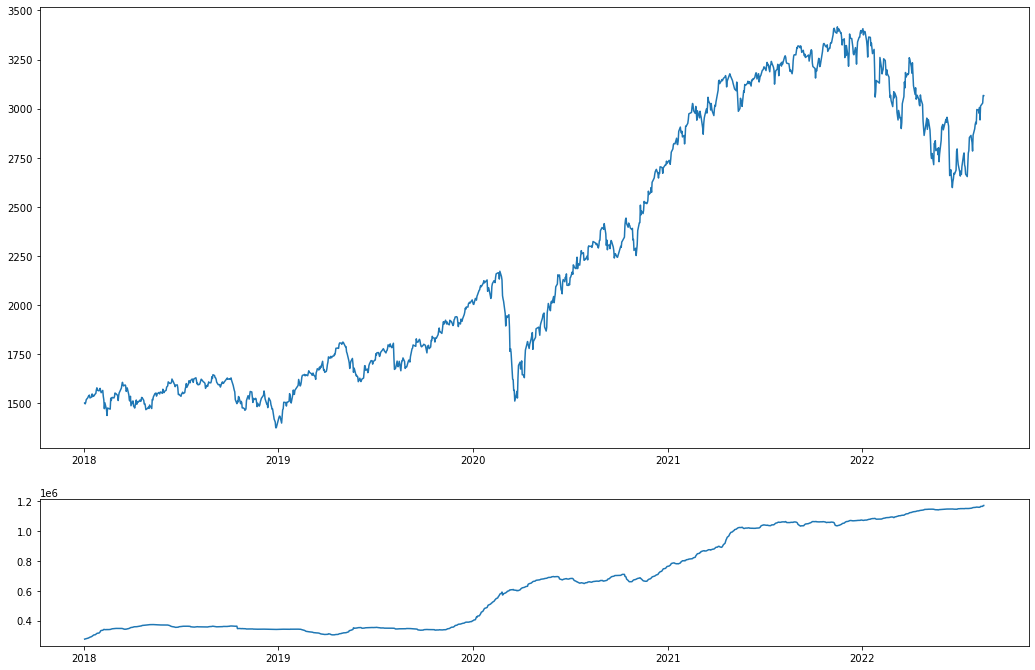

In [13]:
# plt.figure(figsize=(15, 10))
plt.rc('figure', figsize=(15, 10))

fig, axes = plt.subplots(2, 1, gridspec_kw={"height_ratios": [3, 1]} )
fig.tight_layout(pad=3)

plot_price = axes[0]
plot_price.plot(price_df.iloc[:, 0], label="Price")

plot_nav = axes[1]
plot_nav.plot(nav_df.updateStdprc, label="NAV")
# plot_nav.bar(nav_df.updateStdprc.index, nav_df.updateStdprc, width=1)

In [14]:
# fig = px.line(price_df.standardCot, y="standardCot")
# fig.show()

In [15]:
# fig = px.bar(nav_df.updateStdprc, y="updateStdprc")
# fig.show()

In [16]:
fig = plotly.subplots.make_subplots(
    rows=2, 
    cols=1, 
    subplot_titles=("가격", "설정원본 (백만원)")
    )

fig.append_trace(
    go.Scatter(y=price_df.iloc[:, 0], x=price_df.index, name="Price"), 
    row=1,
    col=1,
    )
fig.append_trace(
    go.Scatter(y=nav_df.updateStdprc, x=nav_df.index, name="NAV"),
    row=2,
    col=1,
    )

# fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(height=600, width=1200, title_text=name)
fig.show()

## Fund 구간별 수익률비교

In [17]:
# 설정기간 충분히 긴 것들을 비교하기 위해 정렬
# 하지만 추천펀드들 중 dramatic하게 cumsum return crossover 하는 것 없음. 
sort_by_mindate = []

for idx, fund in fund_dfs_dict.items():
    fund_name = fund[0]
    fund_price_df = fund[2]

    min_date = fund_price_df.index.min()

    sort_by_mindate.append({
        "idx": idx,
        "fund_name": fund_name,
        "min_date": min_date,
    })

sort_by_mindate = sorted(sort_by_mindate, key=lambda x: x["min_date"])
# print(f"""
# Index: {idx}
# Fund: {fund_name}
# min_date: {min_date}
# """)
    
    

### 비교용 펀드 2개 다운로드

In [18]:
fundA_data = {
    "name": "우리프랭클린미국인컴증권모투자신탁(주식혼합-재간접형)",
    "standardCd": "KR5217AD9924",
    "companyCd": "A01007",
    "is_domestic": False,
    "kind": "mix",
}

fundB_data = {
    "name": "미래에셋인도채권증권자투자신탁 1(채권)",
    "standardCd": "K55301AZ7398",
    "companyCd": "A01048",
    "is_domestic": False,
    "kind": "bond",
}

In [19]:
start = 20180101
end = 20220818


In [ ]:


for fund_data in [fundA_data, fundB_data]:
    name = fund_data["name"]
    
    # nav_df = get_fund_data(fund_data, "nav", start, end)
    # nav_df.to_pickle(data_path / "nav" / f"TEST_{start}_to_{end}_{name}_-_nav.pkl")
    
    price_df = get_fund_data(fund_data, "price", start, end)
    price_df.to_pickle(data_path / "price" / f"TEST_{start}_to_{end}_{name}_-_price.pkl")

In [20]:
fundA_name = fundA_data["name"]
fundA_df = pd.read_pickle(data_path / "price" / f"TEST_{start}_to_{end}_{fundA_name}_-_price.pkl" ) # price

fundA_df.rename({"standardCot": fundA_name}, axis=1, inplace=True)
fundA_df = fundA_df.loc[:, fundA_name]

fundB_name = fundB_data["name"]
fundB_df = pd.read_pickle(data_path / "price" / f"TEST_{start}_to_{end}_{fundB_name}_-_price.pkl" ) # price

fundB_df.rename({"standardCot": fundB_name}, axis=1, inplace=True)
fundB_df = fundB_df.loc[:, fundB_name]

In [21]:
fundAB_df = pd.concat([fundA_df, fundB_df], axis=1)

In [23]:
# six_months_date = pd.to_datetime("2021-08-06")
# fundAB_df = fundAB_df.loc[fundAB_df.index >= six_months_date]
fundAB_df.dropna(how="any", inplace=True)

fundAB_ret_df = fundAB_df.pct_change()
fundAB_cumret_df = (fundAB_df.pct_change() + 1).cumprod() - 1


In [27]:
fundAB_ret_df.loc[:, "ret_diff"] = fundAB_ret_df.iloc[:, 0] - fundAB_ret_df.iloc[:, 1]
fundAB_cumret_df.loc[:, "ret_diff"] = fundAB_cumret_df.iloc[:, 0] - fundAB_cumret_df.iloc[:, 1]

In [28]:
fig = plotly.subplots.make_subplots(
    rows=2, 
    cols=1, 
    # subplot_titles=("가격", "설정원본 (백만원)")
    )

fig.append_trace(
    go.Scatter(y=fundAB_cumret_df.iloc[:, 0], x=fundAB_cumret_df.index, name=fundA_name), 
    row=1,
    col=1,
    )
fig.append_trace(
    go.Scatter(y=fundAB_cumret_df.iloc[:, 1], x=fundAB_cumret_df.index, name=fundB_name), 
    row=1,
    col=1,
    )
fig.append_trace(
    go.Bar(y=fundAB_cumret_df.loc[:, "ret_diff"], x=fundAB_cumret_df.index, name="펀드A-펀드B 수익률"),
    row=2,
    col=1,
    )

# fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(height=600, width=1200, title_text=name)
fig.show()

## Quantstat으로 펀드 수익률 plot

`quantstat` 깔려있는 career high project 에서 임시로 했음. 

## Fund correlation 

### High corr funds

In [29]:
# TODO: Fix idx by re-downloading the data. (original data should be deleted)

fundA_idx = 4
fundB_idx = 8

fundA_name = fund_dfs_dict.get(fundA_idx)[0]
fundA_df = fund_dfs_dict.get(fundA_idx)[2] # price
fundA_df.rename({"standardCot": fundA_name}, axis=1, inplace=True)
fundA_df = fundA_df.loc[:, fundA_name]

fundB_name = fund_dfs_dict.get(fundB_idx)[0]
fundB_df = fund_dfs_dict.get(fundB_idx)[2] # price
fundB_df.rename({"standardCot": fundB_name}, axis=1, inplace=True)
fundB_df = fundB_df.loc[:, fundB_name]

In [30]:
fundA_name

'피델리티글로벌테크놀로지증권자투자신탁(주식-재간접형)'

In [31]:
fundB_name

'미래에셋글로벌코어테크EMP증권투자신탁(주식-재간접형)'

In [32]:
fundAB_df = pd.concat([fundA_df, fundB_df], axis=1)

In [33]:
fundAB_df.dropna(how="any", inplace=True)

fundAB_ret_df = fundAB_df.pct_change()
fundAB_cumret_df = (fundAB_df.pct_change() + 1).cumprod() - 1


In [34]:
px.line(fundAB_cumret_df)

In [35]:
fundAB_ret_df.corr()

,피델리티글로벌테크놀로지증권자투자신탁(주식-재간접형),미래에셋글로벌코어테크EMP증권투자신탁(주식-재간접형)
피델리티글로벌테크놀로지증권자투자신탁(주식-재간접형),1.000000,0.689551
미래에셋글로벌코어테크EMP증권투자신탁(주식-재간접형),0.689551,1.000000


In [36]:
rolling_days = 63
s1 = fundAB_ret_df.iloc[:, 0]
s2 = fundAB_ret_df.iloc[:, 1]
fundAB_ret_df.loc[:, "rolling_corr"] = s1.rolling(rolling_days).corr(s2)

In [37]:
px.line(fundAB_ret_df.rolling_corr, title=f"{rolling_days} days rolling correlation between 2 funds")

### Low corr funds

In [92]:
# TODO: Fix idx by re-downloading the data. (original data should be deleted)

fundA_idx = 0
fundB_idx = 6

fundA_name = fund_dfs_dict.get(fundA_idx)[0]
fundA_df = fund_dfs_dict.get(fundA_idx)[2] # price
fundA_df.rename({"standardCot": fundA_name}, axis=1, inplace=True)
fundA_df = fundA_df.loc[:, fundA_name]

fundB_name = fund_dfs_dict.get(fundB_idx)[0]
fundB_df = fund_dfs_dict.get(fundB_idx)[2] # price
fundB_df.rename({"standardCot": fundB_name}, axis=1, inplace=True)
fundB_df = fundB_df.loc[:, fundB_name]

In [93]:
fundA_name

'한국투자한국의제4차산업혁명증권자투자신탁 1(주식)'

In [94]:
fundB_name

'한국투자미국배당귀족증권자투자신탁H(주식)'

In [95]:
fundAB_df = pd.concat([fundA_df, fundB_df], axis=1)

In [96]:
fundAB_df.dropna(how="any", inplace=True)

fundAB_ret_df = fundAB_df.pct_change()
fundAB_cumret_df = (fundAB_df.pct_change() + 1).cumprod() - 1


In [97]:
px.line(fundAB_cumret_df)

In [98]:
fundAB_ret_df.corr()

,한국투자한국의제4차산업혁명증권자투자신탁 1(주식),한국투자미국배당귀족증권자투자신탁H(주식)
한국투자한국의제4차산업혁명증권자투자신탁 1(주식),1.000000,0.243502
한국투자미국배당귀족증권자투자신탁H(주식),0.243502,1.000000


In [99]:
rolling_days = 63
s1 = fundAB_ret_df.iloc[:, 0]
s2 = fundAB_ret_df.iloc[:, 1]
fundAB_ret_df.loc[:, "rolling_corr"] = s1.rolling(rolling_days).corr(s2)

In [100]:
px.line(fundAB_ret_df.rolling_corr, title=f"{rolling_days} days rolling correlation between 2 funds")